In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

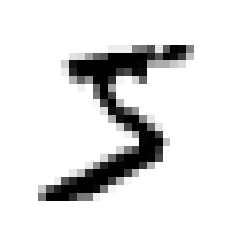

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [9]:
y[0]

'5'

In [10]:
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# Performance measures

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [17]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [20]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision/recall trade-off

In [22]:
y_scores = sgd_clf.decision_function([some_digit])

In [23]:
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recals, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')

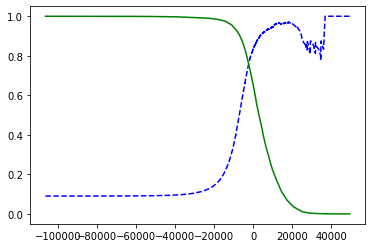

In [29]:
plot_precision_recall_vs_threshold(precisions, recals, thresholds)
plt.show()

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1],  'k--')

[]

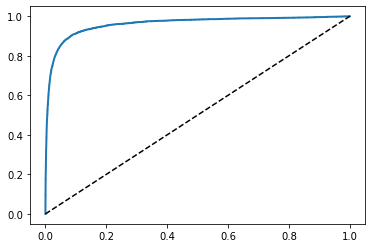

In [36]:
plot_roc_curve(fpr, tpr)
plt.plot()

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [39]:
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

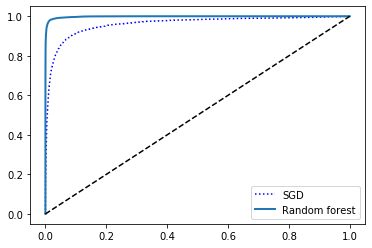

In [40]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random forest")
plt.legend(loc="lower right")
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [42]:
y_train_forest_pred = y_scores_forest> 0.5

In [43]:
print(precision_score(y_train_5, y_train_forest_pred))
print(recall_score(y_train_5, y_train_forest_pred))

0.9905083315756169
0.8662608374838591


In [44]:
y_scores_forest[:10]

array([0.89, 0.01, 0.04, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01])

# Multiclass classification

In [45]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
some_digit_score = svm_clf.decision_function([some_digit])

In [48]:
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
np.argmax(some_digit_score)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

In [53]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [54]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [55]:
len(ovr_clf.estimators_)

10

In [57]:
sgd_clf = SGDClassifier(n_jobs=10)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=10, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [58]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
sgd_clf.decision_function([some_digit])

array([[-11754.05608445, -29336.63569981,  -8386.60495238,
         -1296.66421863, -27655.388184  ,   5554.30855955,
        -17988.87088844, -17231.44179797,  -9506.56841998,
        -14786.45566071]])

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88145, 0.87345, 0.8742 ])

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [62]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/keyran/.conda/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90505, 0.8956 , 0.903  ])

# Error analisys 

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)

/home/keyran/.conda/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/keyran/.conda/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [65]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [66]:
conf_mx

array([[5602,    0,   23,    9,    9,   58,   37,    7,  177,    1],
       [   0, 6420,   37,   27,    4,   45,    4,    8,  183,   14],
       [  27,   27, 5285,   99,   72,   30,   67,   39,  301,   11],
       [  25,   18,  122, 5289,    2,  221,   27,   42,  310,   75],
       [  11,   15,   51,   12, 5239,   11,   40,   27,  249,  187],
       [  29,   17,   34,  183,   55, 4549,   76,   17,  390,   71],
       [  30,   16,   50,    3,   43,   98, 5570,    3,  104,    1],
       [  20,   13,   57,   34,   50,   12,    3, 5722,  120,  234],
       [  20,   65,   47,   96,    3,  126,   28,   11, 5398,   57],
       [  23,   20,   30,   70,  121,   40,    1,  182,  262, 5200]])

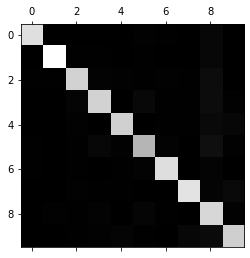

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

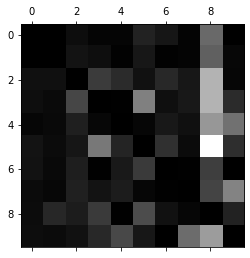

In [70]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

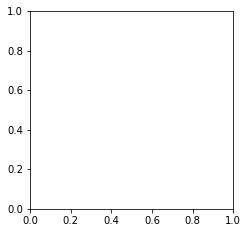

In [71]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred) == cl_a]
X_ab = X_train[(y_train==cl_a) & (y_train_pred) == cl_b]
X_ba = X_train[(y_train==cl_b) & (y_train_pred) == cl_a]
X_bb = X_train[(y_train==cl_b) & (y_train_pred) == cl_b]
plt.figure(figsize = (8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel classification

In [74]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [75]:
y_multilabel[:10, :]

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True],
       [False, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False]])

In [76]:
knn_clf = KNeighborsClassifier(n_jobs=10)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=10, n_neighbors=5, p=2,
                     weights='uniform')

In [77]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [78]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

In [80]:
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted')

0.9778357403921755

# Multioutput classification

In [81]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test


In [82]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[42]])

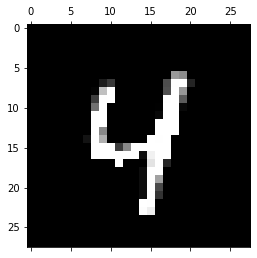

In [87]:
plt.matshow(clean_digit.reshape(28,28), cmap=plt.cm.gray)

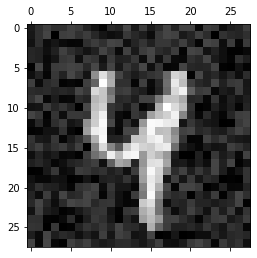

In [88]:
plt.matshow(X_test_mod[42].reshape(28,28), cmap=plt.cm.gray)